# 2- Creation of the RL model
once we have created the simple enviroment we can pass to the second step that is the creation of the RL Model.

First we will consider the gym local enviroment BasicEnv13


In [1]:
import gym
from gym import spaces
import numpy as np
import matplotlib.pyplot as plt
import pygame
from pygame import display
from pygame.surfarray import array3d
import random
import pandas as pd
from PIL import Image
training=True

df= pd.read_csv("test.csv")
feature1=df['island'].max()
feature2=df['project'].max()
feature3=df['energy_consumption'].max()
feature4=df['emp_project'].max()
feature5=df['emp_energy_consumption'].max()
feature6=df['occupied'].max()

max_colors=df['island'].nunique()
low_x=int(df['x_coord'].min())
high_x=int(df['x_coord'].max())
low_y=int(df['y_coord'].min())
high_y=int(df['y_coord'].max())
possible_clicks=df.shape[0]
pos_x=possible_clicks
pos_y=possible_clicks
max_sit=possible_clicks

# get image
filepath = "bg.jpg"
img_bg = Image.open(filepath)
# get width and height
width = img_bg.width
height = img_bg.height
  
font_color=(0,50,250)
WHITE = pygame.Color(255, 255, 255)
RED = (200,0,0)
GREEN = (0, 255, 0)
BLUE = (0, 0, 255)

#Load images
#To the image we assing a kind of gym object
worker_pos=[25,25]
#Target image and position
position_coordinates=[(50,50),
                      (100,50),
                      (150,50)]

target_rects={}
target_images={}
counts = df.groupby(['island'])['island'].count()
reward_dict=counts.to_dict()

def convert_colormap_to_hex(cmap, x, vmin=0, vmax=1):
    """
    Example::
        >>> seaborn.palplot(seaborn.color_palette("RdBu_r", 7))
        >>> colorMapRGB = seaborn.color_palette("RdBu_r", 61)
        >>> colormap = seaborn.blend_palette(colorMapRGB, as_cmap=True, input='rgb')
        >>> [convert_colormap_to_hex(colormap, x, vmin=-2, vmax=2) for x in range(-2, 3)]
        ['#09386d', '#72b1d3', '#f7f6f5', '#e7866a', '#730421']
    """
    norm = colors.Normalize(vmin, vmax)
    color_rgb = plt.cm.get_cmap(cmap)(norm(x))
    color_hex = colors.rgb2hex(color_rgb)
    return color_hex

import  seaborn
from matplotlib import colors
from PIL import ImageColor
colorMapRGB = seaborn.color_palette("RdBu_r", max_colors)
colormap = seaborn.blend_palette(colorMapRGB, as_cmap=True, input='rgb')
cmap_list=[convert_colormap_to_hex(colormap, x, vmin=-int(max_colors/2)-1, vmax=int(max_colors/2)+1) for x in range(-int(max_colors/2)-1, int(max_colors/2)+1)]


class BasicEnv14(gym.Env):
    metadata = {'render.modes': ['human']}
    def __init__(self):
        # There are two actions, first will get reward of 1, second reward of -1. 
        self.action_space = spaces.Discrete(possible_clicks)
        self.observation_space = gym.spaces.Dict(
    {"feature1": gym.spaces.Box(low=0, high=feature1, shape=(1,), dtype=np.uint8),
     "y_position": gym.spaces.Box(low=low_y, high=high_y, shape=(1,), dtype=np.uint8),
     "x_position": gym.spaces.Box(low=low_x, high=high_x, shape=(1,), dtype=np.uint8)
     }
        )
        # We inizialize the display
        self.frame_size_x = width # high_x
        self.frame_size_y = height# high_y
        self.game_window = pygame.display.set_mode((self.frame_size_x, self.frame_size_y))  
        self.reset()

    def reset(self):
        self.game_window.fill(WHITE)
        self.state = None
        self.steps = 0
        self.worker_pos=[25,25] 
        self.score = 0
        self.steps = 0
        action=(0,0)
        img = array3d(display.get_surface())
        img = np.swapaxes(img, 0, 1)
        
        self.STEP_LIMIT = 1000
        #To the image we assing a kind of gym object
        self.worker_rect=pygame.draw.circle(self.game_window,BLUE,(self.worker_pos[0], self.worker_pos[1]),6) # DRAW CIRCLE
        # Moreover we add a position in the screen display
        self.target_rects={} 
        n_space=df.shape[0]
        for num in range(n_space):
            targets=int(df['x_coord'][num]), int(df['y_coord'][num])
            numero_cluster=df['island'][num]
            cmap_color=cmap_list[numero_cluster-1]
            target_images[num] = pygame.draw.circle(self.game_window,cmap_color,(targets[0], targets[1]),6) # DRAW CIRCLE
            self.target_rects[num] = target_images[num]
            #print('Initial positions',targets)
            self.target_rects[num].center = targets
        # Adding text
        pygame.init()
        self.font_color=(0,50,250)                                       # Step 1  Color RGB code
        self.font_obj=pygame.font.Font("C:\Windows\Fonts\Arial.ttf",20)  # Step 2  Select the font type
        # Render the objects
        self.text_obj=self.font_obj.render("Reward:",True,self.font_color) # Step 3  Creation of object text        
        state, reward, done, info = self.step(action) 
        return img        
        #return state, reward, done, info
        
    def reward_value(self,worker,target,num):
        
        #print(Reward check: )
        #Check for collision between two rects            
        if worker.colliderect(target):
            '''
            Reward 1 - The more dense is the cluster more reward  
            Gives the value of the island   number of seats
                0    2
                1    4
                2    4
                3    4
                4    1
            '''
            number_island=df['island'].iloc[num]
            reward1=reward_dict[number_island]

            '''
            Reward 2 - Check if is occupied
                0 - occupied
                1 - free
            '''
            is_occupied=df['occupied'].iloc[num]
           
            '''
            Reward 3 - More neighbors more reward
            '''
            reward3=len(df[(df['island']==number_island) & (df['occupied']==0 )])
            reward=(reward1+reward3)*is_occupied
            
            if is_occupied == 0:
                print('is_occupied',is_occupied)
            else:
                print('reward',reward)
            
            return reward
        
        else:
            
            reward = 0
            return reward
        
        
    def step(self, action):
        reward = 0
        
        
        # Check if variable is  tuple
        # using type()
        #res = type(action) is tuple       
        # Inside gym the test need tuples and not int
        
        if (type(action) == int) or (isinstance(action, np.int64)) :
            action_n=int(action)
            print('action_n',action_n)
            action=int(df['x_coord'][action_n]), int(df['y_coord'][action_n])
        
        self.worker_pos = action
        print('The action is inside step:', action, type(action))
        rewards=[]
        # We update the state of worker_rect and image
        self.update_game_state() 
        
        
        # regardless of the action, game is done after a single step
        if action != None:
            print("The action is :", action)  
            n_space=df.shape[0]
            for num in range(n_space):
                reward = self.reward_value(self.worker_rect,self.target_rects[num],num)
                #print('num',num)

                if reward !=0:
        
                    #print("The worker rect is :",self.worker_rect)
                    #print("The target rect is :",self.target_rects[num] ) 
                    rewards.append(reward)
                    #print("rewards",rewards)
                    
        if len(rewards) < 1:
            reward=0
        else:
            reward=rewards[0]
        

        if training == False:
            # Render the objects
            self.text_obj=self.font_obj.render("Reward :" + str(reward),True,self.font_color) # Step 3  Creation of object text
            #Display text
            self.game_window.blit(self.text_obj,(300,0))         
            
              
        img = self.get_image_array_from_game()
        #done = True
        info = {}
        reward, done = self.game_over(reward) 
        print('reward: {}, done: {}, info: {}, step: {}'.format(reward, done, info,self.steps))
        self.steps += 1
        return img, reward, done, info
    
    def worker_step(self,event):   
        '''
        Takes human keyboard event and then returns it as an action string
        '''
        action = None
        if event.type == pygame.QUIT:
            pygame.quit()
            sys.exit()
            
        #Move based on mouse clicks
        if event.type == pygame.MOUSEBUTTONDOWN:
            #print(event)
            mouse_x = event.pos[0]
            mouse_y = event.pos[1]

            #'CLICK'
            action = mouse_x, mouse_y
        
        #Drag the object when the mouse button is clicked
        if event.type == pygame.MOUSEMOTION and event.buttons[0] == 1:
            #print(event)
            mouse_x = event.pos[0]
            mouse_y = event.pos[1]
    
            #'CLICK'
            action = mouse_x, mouse_y
        
        elif event.type == pygame.KEYDOWN:
        
            # Esc -> Create event to quit the game
            if event.key == pygame.K_ESCAPE:
                pygame.event.post(pygame.event.Event(pygame.QUIT))                       
        return action    
    
    def update_game_state(self):
        #We fill the screen to white
        if training == True:
            self.game_window.fill(WHITE)
        else:    
            bg = pygame.image.load("bg.jpg")
            #Give a background color to the display
            self.game_window.blit(bg, (0, 0))
        # -------------WORKER--------------
        
        #if type(self.worker_pos) == int:
        #    action_n=self.worker_pos
        #    print('action_n in update is:',action_n)
        #    action=int(df['x_coord'][action_n]), int(df['y_coord'][action_n])
        #    self.worker_pos=action    
        
        
        print('self.worker_pos:',self.worker_pos)
        print('worker_pos',self.worker_pos[0],self.worker_pos[1])
        
        self.worker_rect.x=self.worker_pos[0]
        self.worker_rect.y=self.worker_pos[1]
        #Draw rectangles to represent the rect's of each object
        self.worker_rect=pygame.draw.circle(self.game_window,BLUE,(self.worker_rect.x,self.worker_rect.y),6) # DRAW CIRCLE
        
        #-------------- Multiple points TARGETS------------------
        n_space=df.shape[0]
        for num in range(n_space):
            numero_cluster=df['island'][num]
            cmap_color=cmap_list[numero_cluster-1]
            occupied=df['occupied'][num]
            if occupied == 0:
                color=RED
            else:
                color=GREEN
            pygame.draw.circle(self.game_window,color,(self.target_rects[num].x,self.target_rects[num].y),6) # DRAW CIRCLE
            
    def get_image_array_from_game(self):
        img = array3d(display.get_surface())
        #Preprocessing of channels ( needed for tensorflow)
        img = np.swapaxes(img, 0, 1)
        return img    
   
    def render(self, mode='human'):
        if mode == "human":
            display.update()        
    def close(self):
        pass
    
    def game_over(self, reward):
        if reward == 0:
            return -1, True
    
        if self.steps >= 1000:
            return 0, True
        
        return reward, False

pygame 2.1.2 (SDL 2.0.18, Python 3.7.0)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# method 1 - use local test class
env = BasicEnv14()

The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
reward: -1, done: True, info: {}, step: 0


The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
reward: -1, done: True, info: {}, step: 0


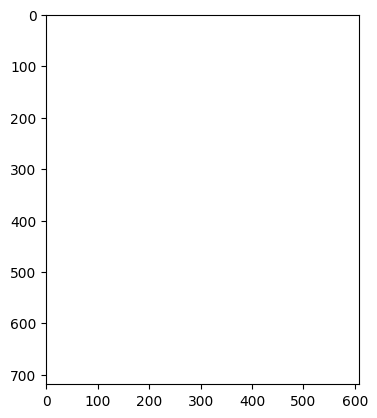

In [3]:
plt.figure()
plt.imshow(env.reset())

action_n 13
The action is inside step: (544, 174) <class 'tuple'>
self.worker_pos: (544, 174)
worker_pos 544 174
The action is : (544, 174)
is_occupied 0
reward: -1, done: True, info: {}, step: 1
Reward = -1 with action = 13


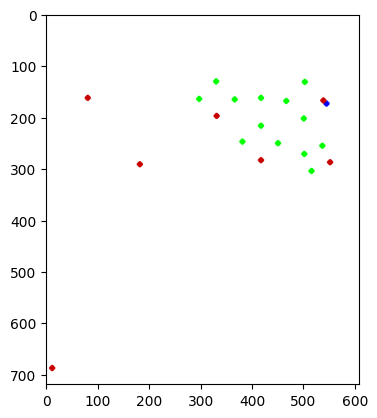

In [4]:
action_n = env.action_space.sample()
state, reward, done, info = env.step(action_n)
print("Reward = {} with action = {}".format(reward,action_n))
#print(state)
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(state)

action_n 1
(521, 311)
The action is inside step: (521, 311) <class 'tuple'>
self.worker_pos: (521, 311)
worker_pos 521 311
The action is : (521, 311)
reward 5
reward: 5, done: False, info: {}, step: 2
Reward = 5 with action = (521, 311)


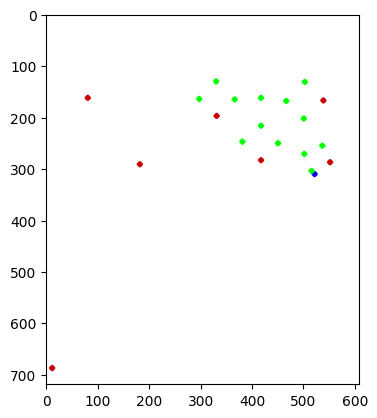

In [5]:
action_n = env.action_space.sample()
print('action_n',action_n)
action=int(df['x_coord'][action_n]), int(df['y_coord'][action_n])
print(action)
state, reward, done, info = env.step(action)
print("Reward = {} with action = {}".format(reward,action))
#print(state)
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(state)

In [6]:
state.shape

(719, 609, 3)

In [5]:
IMG_SHAPE = (84, 84)
WINDOW_LENGTH = 3
input_shape = (WINDOW_LENGTH, IMG_SHAPE[0], IMG_SHAPE[1])
input_shape

(3, 84, 84)

In [9]:
from PIL import Image  # To transform the image in the Processor
import numpy as np
import gym

# Convolutional Backbone Network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Convolution2D, Permute
from tensorflow.keras.optimizers import Adam

# Keras-RL
from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor
from rl.callbacks import FileLogger, ModelIntervalCheckpoint


In [10]:
nb_actions = env.action_space.n

In [11]:
nb_actions

20

In [12]:
IMG_SHAPE = (84, 84)
WINDOW_LENGTH = 3

In [13]:
class ImageProcessor(Processor):
    def process_observation(self, observation):
        # First convert the numpy array to a PIL Image
        img = Image.fromarray(observation)
        # Then resize the image
        img = img.resize(IMG_SHAPE)
        # And convert it to grayscale  (The L stands for luminance)
        img = img.convert("L")
        # Convert the image back to a numpy array and finally return the image
        img = np.array(img)
        return img.astype('uint8')  # saves storage in experience memory
    
    def process_state_batch(self, batch):

        # We divide the observations by 255 to compress it into the intervall [0, 1].
        # This supports the training of the network
        # We perform this operation here to save memory.
        processed_batch = batch.astype('float32') / 255.
        return processed_batch

    def process_reward(self, reward):
        return np.clip(reward, -1., 1.)


In [14]:
class ImageProcessorFix(Processor):
    def process_observation(self,observation):
        if type(observation) == type(None):
            whiteFrame= 255 * np.ones((640,480,3), np.uint8)
            observation=whiteFrame
        # First convert the numpy array to a PIL Image
        img = Image.fromarray(observation)
        # Then resize the image
        img = img.resize(IMG_SHAPE)
        # And convert it to grayscale  (The L stands for luminance)
        #img = img.convert("L")
        # Convert the image back to a numpy array and finally return the image
        img = np.array(img)
        return img.astype('uint8')  # saves storage in experience memory

    def process_state_batch(self, batch):
        # We divide the observations by 255 to compress it into the intervall [0, 1].
        # This supports the training of the network
        # We perform this operation here to save memory.
        processed_batch = batch.astype('float32') / 255.
        return processed_batch

    def process_reward(self, reward):
        return np.clip(reward, -1., 1.)


## Model Creation

**NOTE: Depending on your custom environment, this model will vary greatly, try reading papers that are solving similar problems to your own!**

In [15]:
input_shape = (WINDOW_LENGTH, IMG_SHAPE[0], IMG_SHAPE[1])
input_shape

(3, 84, 84)

In [16]:
model = Sequential()
model.add(Permute((2, 3, 1), input_shape=input_shape))
model.add(Convolution2D(32, (8, 8), strides=(4, 4),kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(Convolution2D(64, (4, 4), strides=(2, 2), kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(Convolution2D(64, (3, 3), strides=(1, 1), kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(nb_actions))
model.add(Activation('linear'))
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 permute (Permute)           (None, 84, 84, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 20, 20, 32)        6176      
                                                                 
 activation (Activation)     (None, 20, 20, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 64)          32832     
                                                                 
 activation_1 (Activation)   (None, 9, 9, 64)          0         
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 activation_2 (Activation)   (None, 7, 7, 64)          0

In [17]:
model2=False
if model2:
    from keras.models import Sequential
    from keras.layers import Dense, Conv2D, Flatten
    #create model
    model = Sequential()
    #add model layers
    model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=input_shape))  # (28,28,1)))
    model.add(Conv2D(32, kernel_size=3, activation='relu'))
    model.add(Flatten())
    model.add(Dense(nb_actions, activation='softmax'))
    print(model.summary())

----
## Creating the Agent

In [18]:
memory = SequentialMemory(limit=1000000, window_length=WINDOW_LENGTH)

In [19]:
processor = ImageProcessor()

In [20]:
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=.1, value_test=.05,
                              nb_steps=1000000)

In [21]:
dqn = DQNAgent(model=model, nb_actions=nb_actions, policy=policy, memory=memory,
               processor=processor, nb_steps_warmup=50000, gamma=.99, target_model_update=10000,
              train_interval=4, delta_clip=1)

In [22]:
dqn.compile(Adam(learning_rate=.00025), metrics=['mae'])

In [25]:
weights_filename = 'test_dqn_worker_weights.h5f'
checkpoint_weights_filename = 'test_dqn_' + "worker" + '_weights_{step}.h5f'
checkpoint_callback = ModelIntervalCheckpoint(checkpoint_weights_filename, interval=100000)

In [26]:
#nb_steps=1500000

In [27]:
dqn.fit(env, nb_steps=1500, callbacks=[checkpoint_callback], log_interval=100000, visualize=False)

Training for 1500 steps ...
The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
reward: -1, done: True, info: {}, step: 0
Interval 1 (0 steps performed)
action_n 1
The action is inside step: (521, 311) <class 'tuple'>
self.worker_pos: (521, 311)
worker_pos 521 311
The action is : (521, 311)
reward 5
reward: 5, done: False, info: {}, step: 1
     1/100000 [..............................] - ETA: 4:14:49 - reward: 1.0000action_n 17
The action is inside step: (87, 169) <class 'tuple'>
self.worker_pos: (87, 169)
worker_pos 87 169
The action is : (87, 169)
is_occupied 0


C:\Users\RMAGANAV\Anaconda3\envs\gym\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


reward: -1, done: True, info: {}, step: 2
The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
reward: -1, done: True, info: {}, step: 0
action_n 3
The action is inside step: (557, 294) <class 'tuple'>
self.worker_pos: (557, 294)
worker_pos 557 294
The action is : (557, 294)
is_occupied 0
reward: -1, done: True, info: {}, step: 1
     3/100000 [..............................] - ETA: 1:02:58 - reward: -0.3333The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
reward: -1, done: True, info: {}, step: 0
action_n 8
The action is inside step: (387, 254) <class 'tuple'>
self.worker_pos: (387, 254)
worker_pos 387 254
The action is : (387, 254)
reward 5
reward: 5, done: False, info: {}, step: 1
action_n 15
The action is inside step: (303, 171) <class 'tuple'>
self.worker_pos: (303, 171)
worker_pos 303 171
The action is : (303, 171)
reward 5
reward: 5, done: False, info: {}, ste

    32/100000 [..............................] - ETA: 49:40 - reward: 0.4375action_n 2
The action is inside step: (188, 298) <class 'tuple'>
self.worker_pos: (188, 298)
worker_pos 188 298
The action is : (188, 298)
is_occupied 0
reward: -1, done: True, info: {}, step: 2
The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
reward: -1, done: True, info: {}, step: 0
action_n 7
The action is inside step: (456, 257) <class 'tuple'>
self.worker_pos: (456, 257)
worker_pos 456 257
The action is : (456, 257)
reward 5
reward: 5, done: False, info: {}, step: 1
    34/100000 [..............................] - ETA: 50:23 - reward: 0.4118action_n 19
The action is inside step: (336, 137) <class 'tuple'>
self.worker_pos: (336, 137)
worker_pos 336 137
The action is : (336, 137)
reward 5
reward: 5, done: False, info: {}, step: 2
action_n 17
The action is inside step: (87, 169) <class 'tuple'>
self.worker_pos: (87, 169)
worker_pos 87 169
The acti

    64/100000 [..............................] - ETA: 51:17 - reward: 0.4062action_n 13
The action is inside step: (544, 174) <class 'tuple'>
self.worker_pos: (544, 174)
worker_pos 544 174
The action is : (544, 174)
is_occupied 0
reward: -1, done: True, info: {}, step: 10
The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
reward: -1, done: True, info: {}, step: 0
action_n 4
The action is inside step: (423, 290) <class 'tuple'>
self.worker_pos: (423, 290)
worker_pos 423 290
The action is : (423, 290)
is_occupied 0
reward: -1, done: True, info: {}, step: 1
    66/100000 [..............................] - ETA: 51:29 - reward: 0.3636The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
reward: -1, done: True, info: {}, step: 0
action_n 5
The action is inside step: (507, 278) <class 'tuple'>
self.worker_pos: (507, 278)
worker_pos 507 278
The action is : (507, 278)
reward 5


action_n 7
The action is inside step: (456, 257) <class 'tuple'>
self.worker_pos: (456, 257)
worker_pos 456 257
The action is : (456, 257)
reward 5
reward: 5, done: False, info: {}, step: 4
    96/100000 [..............................] - ETA: 50:32 - reward: 0.4167action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 5
action_n 12
The action is inside step: (472, 175) <class 'tuple'>
self.worker_pos: (472, 175)
worker_pos 472 175
The action is : (472, 175)
reward 2
reward: 2, done: False, info: {}, step: 6
action_n 9
The action is inside step: (423, 223) <class 'tuple'>
self.worker_pos: (423, 223)
worker_pos 423 223
The action is : (423, 223)
reward 5
reward: 5, done: False, info: {}, step: 7
    99/100000 [..............................] - ETA: 50:03 - reward: 0.4343action_n 18
The action is inside step: (508, 138) <class 'tuple'>
self.worker_pos: (50

   125/100000 [..............................] - ETA: 50:54 - reward: 0.3600action_n 12
The action is inside step: (472, 175) <class 'tuple'>
self.worker_pos: (472, 175)
worker_pos 472 175
The action is : (472, 175)
reward 2
reward: 2, done: False, info: {}, step: 5
action_n 16
The action is inside step: (423, 169) <class 'tuple'>
self.worker_pos: (423, 169)
worker_pos 423 169
The action is : (423, 169)
reward 1
reward: 1, done: False, info: {}, step: 6
action_n 5
The action is inside step: (507, 278) <class 'tuple'>
self.worker_pos: (507, 278)
worker_pos 507 278
The action is : (507, 278)
reward 5
reward: 5, done: False, info: {}, step: 7
   128/100000 [..............................] - ETA: 50:30 - reward: 0.3750action_n 7
The action is inside step: (456, 257) <class 'tuple'>
self.worker_pos: (456, 257)
worker_pos 456 257
The action is : (456, 257)
reward 5
reward: 5, done: False, info: {}, step: 8
action_n 7
The action is inside step: (456, 257) <class 'tuple'>
self.worker_pos: (456

   154/100000 [..............................] - ETA: 50:47 - reward: 0.3377action_n 19
The action is inside step: (336, 137) <class 'tuple'>
self.worker_pos: (336, 137)
worker_pos 336 137
The action is : (336, 137)
reward 5
reward: 5, done: False, info: {}, step: 2
action_n 2
The action is inside step: (188, 298) <class 'tuple'>
self.worker_pos: (188, 298)
worker_pos 188 298
The action is : (188, 298)
is_occupied 0
reward: -1, done: True, info: {}, step: 3
The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
reward: -1, done: True, info: {}, step: 0
action_n 7
The action is inside step: (456, 257) <class 'tuple'>
self.worker_pos: (456, 257)
worker_pos 456 257
The action is : (456, 257)
reward 5
reward: 5, done: False, info: {}, step: 1
   157/100000 [..............................] - ETA: 50:44 - reward: 0.3376action_n 0
The action is inside step: (18, 694) <class 'tuple'>
self.worker_pos: (18, 694)
worker_pos 18 694
The actio

   184/100000 [..............................] - ETA: 50:50 - reward: 0.3152The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
reward: -1, done: True, info: {}, step: 0
action_n 4
The action is inside step: (423, 290) <class 'tuple'>
self.worker_pos: (423, 290)
worker_pos 423 290
The action is : (423, 290)
is_occupied 0
reward: -1, done: True, info: {}, step: 1
The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
reward: -1, done: True, info: {}, step: 0
action_n 16
The action is inside step: (423, 169) <class 'tuple'>
self.worker_pos: (423, 169)
worker_pos 423 169
The action is : (423, 169)
reward 1
reward: 1, done: False, info: {}, step: 1
   186/100000 [..............................] - ETA: 51:07 - reward: 0.3118action_n 9
The action is inside step: (423, 223) <class 'tuple'>
self.worker_pos: (423, 223)
worker_pos 423 223
The action is : (423, 223)
reward 5
reward

action_n 17
The action is inside step: (87, 169) <class 'tuple'>
self.worker_pos: (87, 169)
worker_pos 87 169
The action is : (87, 169)
is_occupied 0
reward: -1, done: True, info: {}, step: 1
   215/100000 [..............................] - ETA: 50:38 - reward: 0.3209The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
reward: -1, done: True, info: {}, step: 0
action_n 5
The action is inside step: (507, 278) <class 'tuple'>
self.worker_pos: (507, 278)
worker_pos 507 278
The action is : (507, 278)
reward 5
reward: 5, done: False, info: {}, step: 1
action_n 13
The action is inside step: (544, 174) <class 'tuple'>
self.worker_pos: (544, 174)
worker_pos 544 174
The action is : (544, 174)
is_occupied 0
reward: -1, done: True, info: {}, step: 2
   217/100000 [..............................] - ETA: 50:41 - reward: 0.3180The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
rewa

action_n 1
The action is inside step: (521, 311) <class 'tuple'>
self.worker_pos: (521, 311)
worker_pos 521 311
The action is : (521, 311)
reward 5
reward: 5, done: False, info: {}, step: 1
action_n 3
The action is inside step: (557, 294) <class 'tuple'>
self.worker_pos: (557, 294)
worker_pos 557 294
The action is : (557, 294)
is_occupied 0
reward: -1, done: True, info: {}, step: 2
   246/100000 [..............................] - ETA: 50:34 - reward: 0.3252The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
reward: -1, done: True, info: {}, step: 0
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 1
action_n 15
The action is inside step: (303, 171) <class 'tuple'>
self.worker_pos: (303, 171)
worker_pos 303 171
The action is : (303, 171)
reward 5
reward: 5, done: False, info: {}, step: 2
   

   274/100000 [..............................] - ETA: 51:05 - reward: 0.3212action_n 12
The action is inside step: (472, 175) <class 'tuple'>
self.worker_pos: (472, 175)
worker_pos 472 175
The action is : (472, 175)
reward 2
reward: 2, done: False, info: {}, step: 2
action_n 2
The action is inside step: (188, 298) <class 'tuple'>
self.worker_pos: (188, 298)
worker_pos 188 298
The action is : (188, 298)
is_occupied 0
reward: -1, done: True, info: {}, step: 3
The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
reward: -1, done: True, info: {}, step: 0
action_n 9
The action is inside step: (423, 223) <class 'tuple'>
self.worker_pos: (423, 223)
worker_pos 423 223
The action is : (423, 223)
reward 5
reward: 5, done: False, info: {}, step: 1
   277/100000 [..............................] - ETA: 51:05 - reward: 0.3213action_n 12
The action is inside step: (472, 175) <class 'tuple'>
self.worker_pos: (472, 175)
worker_pos 472 175
The a

action_n 5
The action is inside step: (507, 278) <class 'tuple'>
self.worker_pos: (507, 278)
worker_pos 507 278
The action is : (507, 278)
reward 5
reward: 5, done: False, info: {}, step: 4
   305/100000 [..............................] - ETA: 51:07 - reward: 0.3180action_n 19
The action is inside step: (336, 137) <class 'tuple'>
self.worker_pos: (336, 137)
worker_pos 336 137
The action is : (336, 137)
reward 5
reward: 5, done: False, info: {}, step: 5
action_n 4
The action is inside step: (423, 290) <class 'tuple'>
self.worker_pos: (423, 290)
worker_pos 423 290
The action is : (423, 290)
is_occupied 0
reward: -1, done: True, info: {}, step: 6
The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
reward: -1, done: True, info: {}, step: 0
action_n 5
The action is inside step: (507, 278) <class 'tuple'>
self.worker_pos: (507, 278)
worker_pos 507 278
The action is : (507, 278)
reward 5
reward: 5, done: False, info: {}, step: 1
   3

action_n 13
The action is inside step: (544, 174) <class 'tuple'>
self.worker_pos: (544, 174)
worker_pos 544 174
The action is : (544, 174)
is_occupied 0
reward: -1, done: True, info: {}, step: 3
   337/100000 [..............................] - ETA: 50:50 - reward: 0.3294The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
reward: -1, done: True, info: {}, step: 0
action_n 13
The action is inside step: (544, 174) <class 'tuple'>
self.worker_pos: (544, 174)
worker_pos 544 174
The action is : (544, 174)
is_occupied 0
reward: -1, done: True, info: {}, step: 1
   338/100000 [..............................] - ETA: 50:57 - reward: 0.3254The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
reward: -1, done: True, info: {}, step: 0
action_n 4
The action is inside step: (423, 290) <class 'tuple'>
self.worker_pos: (423, 290)
worker_pos 423 290
The action is : (423, 290)
is_occupi

   365/100000 [..............................] - ETA: 51:21 - reward: 0.3315action_n 4
The action is inside step: (423, 290) <class 'tuple'>
self.worker_pos: (423, 290)
worker_pos 423 290
The action is : (423, 290)
is_occupied 0
reward: -1, done: True, info: {}, step: 2
The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
reward: -1, done: True, info: {}, step: 0
action_n 13
The action is inside step: (544, 174) <class 'tuple'>
self.worker_pos: (544, 174)
worker_pos 544 174
The action is : (544, 174)
is_occupied 0
reward: -1, done: True, info: {}, step: 1
   367/100000 [..............................] - ETA: 51:24 - reward: 0.3243The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
reward: -1, done: True, info: {}, step: 0
action_n 7
The action is inside step: (456, 257) <class 'tuple'>
self.worker_pos: (456, 257)
worker_pos 456 257
The action is : (456, 257)
reward 5
r

reward: -1, done: True, info: {}, step: 2
The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
reward: -1, done: True, info: {}, step: 0
action_n 2
The action is inside step: (188, 298) <class 'tuple'>
self.worker_pos: (188, 298)
worker_pos 188 298
The action is : (188, 298)
is_occupied 0
reward: -1, done: True, info: {}, step: 1
   395/100000 [..............................] - ETA: 51:38 - reward: 0.3165The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
reward: -1, done: True, info: {}, step: 0
action_n 7
The action is inside step: (456, 257) <class 'tuple'>
self.worker_pos: (456, 257)
worker_pos 456 257
The action is : (456, 257)
reward 5
reward: 5, done: False, info: {}, step: 1
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 

   420/100000 [..............................] - ETA: 52:10 - reward: 0.3000action_n 3
The action is inside step: (557, 294) <class 'tuple'>
self.worker_pos: (557, 294)
worker_pos 557 294
The action is : (557, 294)
is_occupied 0
reward: -1, done: True, info: {}, step: 2
The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
reward: -1, done: True, info: {}, step: 0
action_n 1
The action is inside step: (521, 311) <class 'tuple'>
self.worker_pos: (521, 311)
worker_pos 521 311
The action is : (521, 311)
reward 5
reward: 5, done: False, info: {}, step: 1
   422/100000 [..............................] - ETA: 52:10 - reward: 0.2986action_n 11
The action is inside step: (337, 204) <class 'tuple'>
self.worker_pos: (337, 204)
worker_pos 337 204
The action is : (337, 204)
is_occupied 0
reward: -1, done: True, info: {}, step: 2
The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
r

   448/100000 [..............................] - ETA: 52:16 - reward: 0.2902action_n 4
The action is inside step: (423, 290) <class 'tuple'>
self.worker_pos: (423, 290)
worker_pos 423 290
The action is : (423, 290)
is_occupied 0
reward: -1, done: True, info: {}, step: 2
The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
reward: -1, done: True, info: {}, step: 0
action_n 8
The action is inside step: (387, 254) <class 'tuple'>
self.worker_pos: (387, 254)
worker_pos 387 254
The action is : (387, 254)
reward 5
reward: 5, done: False, info: {}, step: 1
   450/100000 [..............................] - ETA: 52:18 - reward: 0.2889action_n 15
The action is inside step: (303, 171) <class 'tuple'>
self.worker_pos: (303, 171)
worker_pos 303 171
The action is : (303, 171)
reward 5
reward: 5, done: False, info: {}, step: 2
action_n 15
The action is inside step: (303, 171) <class 'tuple'>
self.worker_pos: (303, 171)
worker_pos 303 171
The a

   478/100000 [..............................] - ETA: 52:16 - reward: 0.2929action_n 15
The action is inside step: (303, 171) <class 'tuple'>
self.worker_pos: (303, 171)
worker_pos 303 171
The action is : (303, 171)
reward 5
reward: 5, done: False, info: {}, step: 8
action_n 15
The action is inside step: (303, 171) <class 'tuple'>
self.worker_pos: (303, 171)
worker_pos 303 171
The action is : (303, 171)
reward 5
reward: 5, done: False, info: {}, step: 9
action_n 0
The action is inside step: (18, 694) <class 'tuple'>
self.worker_pos: (18, 694)
worker_pos 18 694
The action is : (18, 694)
is_occupied 0
reward: -1, done: True, info: {}, step: 10
   481/100000 [..............................] - ETA: 52:10 - reward: 0.2931The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
reward: -1, done: True, info: {}, step: 0
action_n 5
The action is inside step: (507, 278) <class 'tuple'>
self.worker_pos: (507, 278)
worker_pos 507 278
The acti

reward: -1, done: True, info: {}, step: 1
   506/100000 [..............................] - ETA: 52:37 - reward: 0.2806The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
reward: -1, done: True, info: {}, step: 0
action_n 17
The action is inside step: (87, 169) <class 'tuple'>
self.worker_pos: (87, 169)
worker_pos 87 169
The action is : (87, 169)
is_occupied 0
reward: -1, done: True, info: {}, step: 1
   507/100000 [..............................] - ETA: 52:43 - reward: 0.2781The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
reward: -1, done: True, info: {}, step: 0
action_n 4
The action is inside step: (423, 290) <class 'tuple'>
self.worker_pos: (423, 290)
worker_pos 423 290
The action is : (423, 290)
is_occupied 0
reward: -1, done: True, info: {}, step: 1
   508/100000 [..............................] - ETA: 52:48 - reward: 0.2756The action is inside step: (0, 0) <

   535/100000 [..............................] - ETA: 52:45 - reward: 0.2822action_n 17
The action is inside step: (87, 169) <class 'tuple'>
self.worker_pos: (87, 169)
worker_pos 87 169
The action is : (87, 169)
is_occupied 0
reward: -1, done: True, info: {}, step: 3
The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
reward: -1, done: True, info: {}, step: 0
action_n 6
The action is inside step: (542, 262) <class 'tuple'>
self.worker_pos: (542, 262)
worker_pos 542 262
The action is : (542, 262)
reward 5
reward: 5, done: False, info: {}, step: 1
   537/100000 [..............................] - ETA: 52:46 - reward: 0.2812action_n 1
The action is inside step: (521, 311) <class 'tuple'>
self.worker_pos: (521, 311)
worker_pos 521 311
The action is : (521, 311)
reward 5
reward: 5, done: False, info: {}, step: 2
action_n 16
The action is inside step: (423, 169) <class 'tuple'>
self.worker_pos: (423, 169)
worker_pos 423 169
The actio

   565/100000 [..............................] - ETA: 52:35 - reward: 0.2814The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
reward: -1, done: True, info: {}, step: 0
action_n 13
The action is inside step: (544, 174) <class 'tuple'>
self.worker_pos: (544, 174)
worker_pos 544 174
The action is : (544, 174)
is_occupied 0
reward: -1, done: True, info: {}, step: 1
The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
reward: -1, done: True, info: {}, step: 0
action_n 1
The action is inside step: (521, 311) <class 'tuple'>
self.worker_pos: (521, 311)
worker_pos 521 311
The action is : (521, 311)
reward 5
reward: 5, done: False, info: {}, step: 1
   567/100000 [..............................] - ETA: 52:42 - reward: 0.2804action_n 6
The action is inside step: (542, 262) <class 'tuple'>
self.worker_pos: (542, 262)
worker_pos 542 262
The action is : (542, 262)
reward 5
reward

action_n 5
The action is inside step: (507, 278) <class 'tuple'>
self.worker_pos: (507, 278)
worker_pos 507 278
The action is : (507, 278)
reward 5
reward: 5, done: False, info: {}, step: 1
action_n 6
The action is inside step: (542, 262) <class 'tuple'>
self.worker_pos: (542, 262)
worker_pos 542 262
The action is : (542, 262)
reward 5
reward: 5, done: False, info: {}, step: 2
   591/100000 [..............................] - ETA: 53:09 - reward: 0.2623action_n 8
The action is inside step: (387, 254) <class 'tuple'>
self.worker_pos: (387, 254)
worker_pos 387 254
The action is : (387, 254)
reward 5
reward: 5, done: False, info: {}, step: 3
action_n 14
The action is inside step: (372, 172) <class 'tuple'>
self.worker_pos: (372, 172)
worker_pos 372 172
The action is : (372, 172)
reward 5
reward: 5, done: False, info: {}, step: 4
action_n 18
The action is inside step: (508, 138) <class 'tuple'>
self.worker_pos: (508, 138)
worker_pos 508 138
The action is : (508, 138)
reward 1
reward: 1, don

action_n 13
The action is inside step: (544, 174) <class 'tuple'>
self.worker_pos: (544, 174)
worker_pos 544 174
The action is : (544, 174)
is_occupied 0
reward: -1, done: True, info: {}, step: 1
   622/100000 [..............................] - ETA: 53:02 - reward: 0.2701The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
reward: -1, done: True, info: {}, step: 0
action_n 15
The action is inside step: (303, 171) <class 'tuple'>
self.worker_pos: (303, 171)
worker_pos 303 171
The action is : (303, 171)
reward 5
reward: 5, done: False, info: {}, step: 1
   623/100000 [..............................] - ETA: 53:06 - reward: 0.2713action_n 19
The action is inside step: (336, 137) <class 'tuple'>
self.worker_pos: (336, 137)
worker_pos 336 137
The action is : (336, 137)
reward 5
reward: 5, done: False, info: {}, step: 2
action_n 8
The action is inside step: (387, 254) <class 'tuple'>
self.worker_pos: (387, 254)
worker_pos 387 254
The 

action_n 4
The action is inside step: (423, 290) <class 'tuple'>
self.worker_pos: (423, 290)
worker_pos 423 290
The action is : (423, 290)
is_occupied 0
reward: -1, done: True, info: {}, step: 5
   652/100000 [..............................] - ETA: 53:03 - reward: 0.2730The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
reward: -1, done: True, info: {}, step: 0
action_n 0
The action is inside step: (18, 694) <class 'tuple'>
self.worker_pos: (18, 694)
worker_pos 18 694
The action is : (18, 694)
is_occupied 0
reward: -1, done: True, info: {}, step: 1
   653/100000 [..............................] - ETA: 53:07 - reward: 0.2711The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
reward: -1, done: True, info: {}, step: 0
action_n 8
The action is inside step: (387, 254) <class 'tuple'>
self.worker_pos: (387, 254)
worker_pos 387 254
The action is : (387, 254)
reward 5
reward

   682/100000 [..............................] - ETA: 52:51 - reward: 0.2815The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
reward: -1, done: True, info: {}, step: 0
action_n 15
The action is inside step: (303, 171) <class 'tuple'>
self.worker_pos: (303, 171)
worker_pos 303 171
The action is : (303, 171)
reward 5
reward: 5, done: False, info: {}, step: 1
   683/100000 [..............................] - ETA: 52:54 - reward: 0.2826action_n 3
The action is inside step: (557, 294) <class 'tuple'>
self.worker_pos: (557, 294)
worker_pos 557 294
The action is : (557, 294)
is_occupied 0
reward: -1, done: True, info: {}, step: 2
The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
reward: -1, done: True, info: {}, step: 0
action_n 18
The action is inside step: (508, 138) <class 'tuple'>
self.worker_pos: (508, 138)
worker_pos 508 138
The action is : (508, 138)
reward 1
rewar

   712/100000 [..............................] - ETA: 52:44 - reward: 0.2865The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
reward: -1, done: True, info: {}, step: 0
action_n 3
The action is inside step: (557, 294) <class 'tuple'>
self.worker_pos: (557, 294)
worker_pos 557 294
The action is : (557, 294)
is_occupied 0
reward: -1, done: True, info: {}, step: 1
The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
reward: -1, done: True, info: {}, step: 0
action_n 2
The action is inside step: (188, 298) <class 'tuple'>
self.worker_pos: (188, 298)
worker_pos 188 298
The action is : (188, 298)
is_occupied 0
reward: -1, done: True, info: {}, step: 1
   714/100000 [..............................] - ETA: 52:48 - reward: 0.2829The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
reward: -1, done: True, info: {}, step

reward: -1, done: True, info: {}, step: 0
action_n 14
The action is inside step: (372, 172) <class 'tuple'>
self.worker_pos: (372, 172)
worker_pos 372 172
The action is : (372, 172)
reward 5
reward: 5, done: False, info: {}, step: 1
   742/100000 [..............................] - ETA: 52:44 - reward: 0.2857action_n 18
The action is inside step: (508, 138) <class 'tuple'>
self.worker_pos: (508, 138)
worker_pos 508 138
The action is : (508, 138)
reward 1
reward: 1, done: False, info: {}, step: 2
action_n 4
The action is inside step: (423, 290) <class 'tuple'>
self.worker_pos: (423, 290)
worker_pos 423 290
The action is : (423, 290)
is_occupied 0
reward: -1, done: True, info: {}, step: 3
The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
reward: -1, done: True, info: {}, step: 0
action_n 19
The action is inside step: (336, 137) <class 'tuple'>
self.worker_pos: (336, 137)
worker_pos 336 137
The action is : (336, 137)
reward 5
re

   772/100000 [..............................] - ETA: 52:47 - reward: 0.2850action_n 13
The action is inside step: (544, 174) <class 'tuple'>
self.worker_pos: (544, 174)
worker_pos 544 174
The action is : (544, 174)
is_occupied 0
reward: -1, done: True, info: {}, step: 2
The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
reward: -1, done: True, info: {}, step: 0
action_n 19
The action is inside step: (336, 137) <class 'tuple'>
self.worker_pos: (336, 137)
worker_pos 336 137
The action is : (336, 137)
reward 5
reward: 5, done: False, info: {}, step: 1
   774/100000 [..............................] - ETA: 52:48 - reward: 0.2842action_n 16
The action is inside step: (423, 169) <class 'tuple'>
self.worker_pos: (423, 169)
worker_pos 423 169
The action is : (423, 169)
reward 1
reward: 1, done: False, info: {}, step: 2
action_n 4
The action is inside step: (423, 290) <class 'tuple'>
self.worker_pos: (423, 290)
worker_pos 423 290
The 

   803/100000 [..............................] - ETA: 52:39 - reward: 0.2902action_n 0
The action is inside step: (18, 694) <class 'tuple'>
self.worker_pos: (18, 694)
worker_pos 18 694
The action is : (18, 694)
is_occupied 0
reward: -1, done: True, info: {}, step: 2
The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
reward: -1, done: True, info: {}, step: 0
action_n 7
The action is inside step: (456, 257) <class 'tuple'>
self.worker_pos: (456, 257)
worker_pos 456 257
The action is : (456, 257)
reward 5
reward: 5, done: False, info: {}, step: 1
   805/100000 [..............................] - ETA: 52:40 - reward: 0.2894action_n 15
The action is inside step: (303, 171) <class 'tuple'>
self.worker_pos: (303, 171)
worker_pos 303 171
The action is : (303, 171)
reward 5
reward: 5, done: False, info: {}, step: 2
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The actio

The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
reward: -1, done: True, info: {}, step: 0
action_n 1
The action is inside step: (521, 311) <class 'tuple'>
self.worker_pos: (521, 311)
worker_pos 521 311
The action is : (521, 311)
reward 5
reward: 5, done: False, info: {}, step: 1
   836/100000 [..............................] - ETA: 52:33 - reward: 0.2967action_n 11
The action is inside step: (337, 204) <class 'tuple'>
self.worker_pos: (337, 204)
worker_pos 337 204
The action is : (337, 204)
is_occupied 0
reward: -1, done: True, info: {}, step: 2
The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
reward: -1, done: True, info: {}, step: 0
action_n 16
The action is inside step: (423, 169) <class 'tuple'>
self.worker_pos: (423, 169)
worker_pos 423 169
The action is : (423, 169)
reward 1
reward: 1, done: False, info: {}, step: 1
   838/100000 [........................

   869/100000 [..............................] - ETA: 52:20 - reward: 0.3049The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
reward: -1, done: True, info: {}, step: 0
action_n 1
The action is inside step: (521, 311) <class 'tuple'>
self.worker_pos: (521, 311)
worker_pos 521 311
The action is : (521, 311)
reward 5
reward: 5, done: False, info: {}, step: 1
action_n 0
The action is inside step: (18, 694) <class 'tuple'>
self.worker_pos: (18, 694)
worker_pos 18 694
The action is : (18, 694)
is_occupied 0
reward: -1, done: True, info: {}, step: 2
   871/100000 [..............................] - ETA: 52:21 - reward: 0.3042The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
reward: -1, done: True, info: {}, step: 0
action_n 14
The action is inside step: (372, 172) <class 'tuple'>
self.worker_pos: (372, 172)
worker_pos 372 172
The action is : (372, 172)
reward 5
reward: 5,

   897/100000 [..............................] - ETA: 52:34 - reward: 0.2999action_n 12
The action is inside step: (472, 175) <class 'tuple'>
self.worker_pos: (472, 175)
worker_pos 472 175
The action is : (472, 175)
reward 2
reward: 2, done: False, info: {}, step: 5
action_n 7
The action is inside step: (456, 257) <class 'tuple'>
self.worker_pos: (456, 257)
worker_pos 456 257
The action is : (456, 257)
reward 5
reward: 5, done: False, info: {}, step: 6
action_n 18
The action is inside step: (508, 138) <class 'tuple'>
self.worker_pos: (508, 138)
worker_pos 508 138
The action is : (508, 138)
reward 1
reward: 1, done: False, info: {}, step: 7
   900/100000 [..............................] - ETA: 52:31 - reward: 0.3022action_n 13
The action is inside step: (544, 174) <class 'tuple'>
self.worker_pos: (544, 174)
worker_pos 544 174
The action is : (544, 174)
is_occupied 0
reward: -1, done: True, info: {}, step: 8
The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker

   927/100000 [..............................] - ETA: 52:36 - reward: 0.2967The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
reward: -1, done: True, info: {}, step: 0
action_n 0
The action is inside step: (18, 694) <class 'tuple'>
self.worker_pos: (18, 694)
worker_pos 18 694
The action is : (18, 694)
is_occupied 0
reward: -1, done: True, info: {}, step: 1
   928/100000 [..............................] - ETA: 52:38 - reward: 0.2953The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
reward: -1, done: True, info: {}, step: 0
action_n 19
The action is inside step: (336, 137) <class 'tuple'>
self.worker_pos: (336, 137)
worker_pos 336 137
The action is : (336, 137)
reward 5
reward: 5, done: False, info: {}, step: 1
   929/100000 [..............................] - ETA: 52:40 - reward: 0.2960action_n 4
The action is inside step: (423, 290) <class 'tuple'>
self.worker_pos: 

action_n 8
The action is inside step: (387, 254) <class 'tuple'>
self.worker_pos: (387, 254)
worker_pos 387 254
The action is : (387, 254)
reward 5
reward: 5, done: False, info: {}, step: 1
   952/100000 [..............................] - ETA: 52:57 - reward: 0.2836action_n 11
The action is inside step: (337, 204) <class 'tuple'>
self.worker_pos: (337, 204)
worker_pos 337 204
The action is : (337, 204)
is_occupied 0
reward: -1, done: True, info: {}, step: 2
The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
reward: -1, done: True, info: {}, step: 0
action_n 17
The action is inside step: (87, 169) <class 'tuple'>
self.worker_pos: (87, 169)
worker_pos 87 169
The action is : (87, 169)
is_occupied 0
reward: -1, done: True, info: {}, step: 1
   954/100000 [..............................] - ETA: 52:57 - reward: 0.2809The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
rewa

   980/100000 [..............................] - ETA: 53:01 - reward: 0.2776The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
reward: -1, done: True, info: {}, step: 0
action_n 15
The action is inside step: (303, 171) <class 'tuple'>
self.worker_pos: (303, 171)
worker_pos 303 171
The action is : (303, 171)
reward 5
reward: 5, done: False, info: {}, step: 1
action_n 6
The action is inside step: (542, 262) <class 'tuple'>
self.worker_pos: (542, 262)
worker_pos 542 262
The action is : (542, 262)
reward 5
reward: 5, done: False, info: {}, step: 2
   982/100000 [..............................] - ETA: 53:01 - reward: 0.2790action_n 5
The action is inside step: (507, 278) <class 'tuple'>
self.worker_pos: (507, 278)
worker_pos 507 278
The action is : (507, 278)
reward 5
reward: 5, done: False, info: {}, step: 3
action_n 5
The action is inside step: (507, 278) <class 'tuple'>
self.worker_pos: (507, 278)
worker_pos 507 278
The action 

  1010/100000 [..............................] - ETA: 52:59 - reward: 0.2812action_n 14
The action is inside step: (372, 172) <class 'tuple'>
self.worker_pos: (372, 172)
worker_pos 372 172
The action is : (372, 172)
reward 5
reward: 5, done: False, info: {}, step: 5
action_n 16
The action is inside step: (423, 169) <class 'tuple'>
self.worker_pos: (423, 169)
worker_pos 423 169
The action is : (423, 169)
reward 1
reward: 1, done: False, info: {}, step: 6
action_n 11
The action is inside step: (337, 204) <class 'tuple'>
self.worker_pos: (337, 204)
worker_pos 337 204
The action is : (337, 204)
is_occupied 0
reward: -1, done: True, info: {}, step: 7
  1013/100000 [..............................] - ETA: 52:55 - reward: 0.2813The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
reward: -1, done: True, info: {}, step: 0
action_n 19
The action is inside step: (336, 137) <class 'tuple'>
self.worker_pos: (336, 137)
worker_pos 336 137
The

  1041/100000 [..............................] - ETA: 52:54 - reward: 0.2815The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
reward: -1, done: True, info: {}, step: 0
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 1
action_n 17
The action is inside step: (87, 169) <class 'tuple'>
self.worker_pos: (87, 169)
worker_pos 87 169
The action is : (87, 169)
is_occupied 0
reward: -1, done: True, info: {}, step: 2
  1043/100000 [..............................] - ETA: 52:55 - reward: 0.2809The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
reward: -1, done: True, info: {}, step: 0
action_n 13
The action is inside step: (544, 174) <class 'tuple'>
self.worker_pos: (544, 174)
worker_pos 544 174
The action is : (544, 174)
is_occupied 0
rew

action_n 19
The action is inside step: (336, 137) <class 'tuple'>
self.worker_pos: (336, 137)
worker_pos 336 137
The action is : (336, 137)
reward 5
reward: 5, done: False, info: {}, step: 4
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 5
  1071/100000 [..............................] - ETA: 52:54 - reward: 0.2829action_n 7
The action is inside step: (456, 257) <class 'tuple'>
self.worker_pos: (456, 257)
worker_pos 456 257
The action is : (456, 257)
reward 5
reward: 5, done: False, info: {}, step: 6
action_n 5
The action is inside step: (507, 278) <class 'tuple'>
self.worker_pos: (507, 278)
worker_pos 507 278
The action is : (507, 278)
reward 5
reward: 5, done: False, info: {}, step: 7
action_n 8
The action is inside step: (387, 254) <class 'tuple'>
self.worker_pos: (387, 254)
worker_pos 387 254
The action is : (387, 254)
reward 5
reward: 5, don

  1100/100000 [..............................] - ETA: 52:49 - reward: 0.2836action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 2
action_n 5
The action is inside step: (507, 278) <class 'tuple'>
self.worker_pos: (507, 278)
worker_pos 507 278
The action is : (507, 278)
reward 5
reward: 5, done: False, info: {}, step: 3
action_n 19
The action is inside step: (336, 137) <class 'tuple'>
self.worker_pos: (336, 137)
worker_pos 336 137
The action is : (336, 137)
reward 5
reward: 5, done: False, info: {}, step: 4
  1103/100000 [..............................] - ETA: 52:46 - reward: 0.2856action_n 7
The action is inside step: (456, 257) <class 'tuple'>
self.worker_pos: (456, 257)
worker_pos 456 257
The action is : (456, 257)
reward 5
reward: 5, done: False, info: {}, step: 5
action_n 4
The action is inside step: (423, 290) <class 'tuple'>
self.worker_pos: (423

action_n 7
The action is inside step: (456, 257) <class 'tuple'>
self.worker_pos: (456, 257)
worker_pos 456 257
The action is : (456, 257)
reward 5
reward: 5, done: False, info: {}, step: 1
action_n 13
The action is inside step: (544, 174) <class 'tuple'>
self.worker_pos: (544, 174)
worker_pos 544 174
The action is : (544, 174)
is_occupied 0
reward: -1, done: True, info: {}, step: 2
  1128/100000 [..............................] - ETA: 52:55 - reward: 0.2748The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
reward: -1, done: True, info: {}, step: 0
action_n 8
The action is inside step: (387, 254) <class 'tuple'>
self.worker_pos: (387, 254)
worker_pos 387 254
The action is : (387, 254)
reward 5
reward: 5, done: False, info: {}, step: 1
action_n 1
The action is inside step: (521, 311) <class 'tuple'>
self.worker_pos: (521, 311)
worker_pos 521 311
The action is : (521, 311)
reward 5
reward: 5, done: False, info: {}, step: 2
  11

  1160/100000 [..............................] - ETA: 52:40 - reward: 0.2845action_n 9
The action is inside step: (423, 223) <class 'tuple'>
self.worker_pos: (423, 223)
worker_pos 423 223
The action is : (423, 223)
reward 5
reward: 5, done: False, info: {}, step: 2
action_n 1
The action is inside step: (521, 311) <class 'tuple'>
self.worker_pos: (521, 311)
worker_pos 521 311
The action is : (521, 311)
reward 5
reward: 5, done: False, info: {}, step: 3
action_n 7
The action is inside step: (456, 257) <class 'tuple'>
self.worker_pos: (456, 257)
worker_pos 456 257
The action is : (456, 257)
reward 5
reward: 5, done: False, info: {}, step: 4
  1163/100000 [..............................] - ETA: 52:37 - reward: 0.2863action_n 11
The action is inside step: (337, 204) <class 'tuple'>
self.worker_pos: (337, 204)
worker_pos 337 204
The action is : (337, 204)
is_occupied 0
reward: -1, done: True, info: {}, step: 5
The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_p

  1190/100000 [..............................] - ETA: 52:34 - reward: 0.2857action_n 11
The action is inside step: (337, 204) <class 'tuple'>
self.worker_pos: (337, 204)
worker_pos 337 204
The action is : (337, 204)
is_occupied 0
reward: -1, done: True, info: {}, step: 3
The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
reward: -1, done: True, info: {}, step: 0
action_n 11
The action is inside step: (337, 204) <class 'tuple'>
self.worker_pos: (337, 204)
worker_pos 337 204
The action is : (337, 204)
is_occupied 0
reward: -1, done: True, info: {}, step: 1
  1192/100000 [..............................] - ETA: 52:35 - reward: 0.2836The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
reward: -1, done: True, info: {}, step: 0
action_n 8
The action is inside step: (387, 254) <class 'tuple'>
self.worker_pos: (387, 254)
worker_pos 387 254
The action is : (387, 254)
reward 5


action_n 8
The action is inside step: (387, 254) <class 'tuple'>
self.worker_pos: (387, 254)
worker_pos 387 254
The action is : (387, 254)
reward 5
reward: 5, done: False, info: {}, step: 3
action_n 12
The action is inside step: (472, 175) <class 'tuple'>
self.worker_pos: (472, 175)
worker_pos 472 175
The action is : (472, 175)
reward 2
reward: 2, done: False, info: {}, step: 4
  1220/100000 [..............................] - ETA: 52:33 - reward: 0.2836action_n 7
The action is inside step: (456, 257) <class 'tuple'>
self.worker_pos: (456, 257)
worker_pos 456 257
The action is : (456, 257)
reward 5
reward: 5, done: False, info: {}, step: 5
action_n 16
The action is inside step: (423, 169) <class 'tuple'>
self.worker_pos: (423, 169)
worker_pos 423 169
The action is : (423, 169)
reward 1
reward: 1, done: False, info: {}, step: 6
action_n 8
The action is inside step: (387, 254) <class 'tuple'>
self.worker_pos: (387, 254)
worker_pos 387 254
The action is : (387, 254)
reward 5
reward: 5, don

  1248/100000 [..............................] - ETA: 52:30 - reward: 0.2821The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
reward: -1, done: True, info: {}, step: 0
action_n 4
The action is inside step: (423, 290) <class 'tuple'>
self.worker_pos: (423, 290)
worker_pos 423 290
The action is : (423, 290)
is_occupied 0
reward: -1, done: True, info: {}, step: 1
The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
reward: -1, done: True, info: {}, step: 0
action_n 13
The action is inside step: (544, 174) <class 'tuple'>
self.worker_pos: (544, 174)
worker_pos 544 174
The action is : (544, 174)
is_occupied 0
reward: -1, done: True, info: {}, step: 1
  1250/100000 [..............................] - ETA: 52:32 - reward: 0.2800The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
reward: -1, done: True, info: {}, ste

  1277/100000 [..............................] - ETA: 52:27 - reward: 0.2827action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 2
action_n 6
The action is inside step: (542, 262) <class 'tuple'>
self.worker_pos: (542, 262)
worker_pos 542 262
The action is : (542, 262)
reward 5
reward: 5, done: False, info: {}, step: 3
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 4
  1280/100000 [..............................] - ETA: 52:25 - reward: 0.2844action_n 0
The action is inside step: (18, 694) <class 'tuple'>
self.worker_pos: (18, 694)
worker_pos 18 694
The action is : (18, 694)
is_occupied 0
reward: -1, done: True, info: {}, step: 5
The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 

  1311/100000 [..............................] - ETA: 52:09 - reward: 0.2937action_n 17
The action is inside step: (87, 169) <class 'tuple'>
self.worker_pos: (87, 169)
worker_pos 87 169
The action is : (87, 169)
is_occupied 0
reward: -1, done: True, info: {}, step: 2
The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
reward: -1, done: True, info: {}, step: 0
action_n 5
The action is inside step: (507, 278) <class 'tuple'>
self.worker_pos: (507, 278)
worker_pos 507 278
The action is : (507, 278)
reward 5
reward: 5, done: False, info: {}, step: 1
  1313/100000 [..............................] - ETA: 52:10 - reward: 0.2932action_n 7
The action is inside step: (456, 257) <class 'tuple'>
self.worker_pos: (456, 257)
worker_pos 456 257
The action is : (456, 257)
reward 5
reward: 5, done: False, info: {}, step: 2
action_n 16
The action is inside step: (423, 169) <class 'tuple'>
self.worker_pos: (423, 169)
worker_pos 423 169
The actio

  1345/100000 [..............................] - ETA: 51:55 - reward: 0.2996The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
reward: -1, done: True, info: {}, step: 0
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 1
  1346/100000 [..............................] - ETA: 51:57 - reward: 0.3001action_n 15
The action is inside step: (303, 171) <class 'tuple'>
self.worker_pos: (303, 171)
worker_pos 303 171
The action is : (303, 171)
reward 5
reward: 5, done: False, info: {}, step: 2
action_n 16
The action is inside step: (423, 169) <class 'tuple'>
self.worker_pos: (423, 169)
worker_pos 423 169
The action is : (423, 169)
reward 1
reward: 1, done: False, info: {}, step: 3
action_n 17
The action is inside step: (87, 169) <class 'tuple'>
self.worker_pos: (87, 169)
worker_pos 87 169
The action 

  1376/100000 [..............................] - ETA: 51:50 - reward: 0.3009The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
reward: -1, done: True, info: {}, step: 0
action_n 0
The action is inside step: (18, 694) <class 'tuple'>
self.worker_pos: (18, 694)
worker_pos 18 694
The action is : (18, 694)
is_occupied 0
reward: -1, done: True, info: {}, step: 1
The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
reward: -1, done: True, info: {}, step: 0
action_n 13
The action is inside step: (544, 174) <class 'tuple'>
self.worker_pos: (544, 174)
worker_pos 544 174
The action is : (544, 174)
is_occupied 0
reward: -1, done: True, info: {}, step: 1
  1378/100000 [..............................] - ETA: 51:52 - reward: 0.2990The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
reward: -1, done: True, info: {}, step: 0

  1404/100000 [..............................] - ETA: 51:54 - reward: 0.2963The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
reward: -1, done: True, info: {}, step: 0
action_n 19
The action is inside step: (336, 137) <class 'tuple'>
self.worker_pos: (336, 137)
worker_pos 336 137
The action is : (336, 137)
reward 5
reward: 5, done: False, info: {}, step: 1
action_n 3
The action is inside step: (557, 294) <class 'tuple'>
self.worker_pos: (557, 294)
worker_pos 557 294
The action is : (557, 294)
is_occupied 0
reward: -1, done: True, info: {}, step: 2
  1406/100000 [..............................] - ETA: 51:54 - reward: 0.2959The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
reward: -1, done: True, info: {}, step: 0
action_n 9
The action is inside step: (423, 223) <class 'tuple'>
self.worker_pos: (423, 223)
worker_pos 423 223
The action is : (423, 223)
reward 5
reward

action_n 16
The action is inside step: (423, 169) <class 'tuple'>
self.worker_pos: (423, 169)
worker_pos 423 169
The action is : (423, 169)
reward 1
reward: 1, done: False, info: {}, step: 6
action_n 9
The action is inside step: (423, 223) <class 'tuple'>
self.worker_pos: (423, 223)
worker_pos 423 223
The action is : (423, 223)
reward 5
reward: 5, done: False, info: {}, step: 7
  1435/100000 [..............................] - ETA: 51:51 - reward: 0.2976action_n 13
The action is inside step: (544, 174) <class 'tuple'>
self.worker_pos: (544, 174)
worker_pos 544 174
The action is : (544, 174)
is_occupied 0
reward: -1, done: True, info: {}, step: 8
The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
reward: -1, done: True, info: {}, step: 0
action_n 19
The action is inside step: (336, 137) <class 'tuple'>
self.worker_pos: (336, 137)
worker_pos 336 137
The action is : (336, 137)
reward 5
reward: 5, done: False, info: {}, step: 1
  

  1467/100000 [..............................] - ETA: 51:43 - reward: 0.3061action_n 7
The action is inside step: (456, 257) <class 'tuple'>
self.worker_pos: (456, 257)
worker_pos 456 257
The action is : (456, 257)
reward 5
reward: 5, done: False, info: {}, step: 18
action_n 0
The action is inside step: (18, 694) <class 'tuple'>
self.worker_pos: (18, 694)
worker_pos 18 694
The action is : (18, 694)
is_occupied 0
reward: -1, done: True, info: {}, step: 19
  1469/100000 [..............................] - ETA: 51:42 - reward: 0.3057The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
reward: -1, done: True, info: {}, step: 0
action_n 2
The action is inside step: (188, 298) <class 'tuple'>
self.worker_pos: (188, 298)
worker_pos 188 298
The action is : (188, 298)
is_occupied 0
reward: -1, done: True, info: {}, step: 1
  1470/100000 [..............................] - ETA: 51:44 - reward: 0.3048The action is inside step: (0, 0) <class

  1495/100000 [..............................] - ETA: 51:46 - reward: 0.3043action_n 2
The action is inside step: (188, 298) <class 'tuple'>
self.worker_pos: (188, 298)
worker_pos 188 298
The action is : (188, 298)
is_occupied 0
reward: -1, done: True, info: {}, step: 5
The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
reward: -1, done: True, info: {}, step: 0
action_n 6
The action is inside step: (542, 262) <class 'tuple'>
self.worker_pos: (542, 262)
worker_pos 542 262
The action is : (542, 262)
reward 5
reward: 5, done: False, info: {}, step: 1
  1497/100000 [..............................] - ETA: 51:47 - reward: 0.3039action_n 12
The action is inside step: (472, 175) <class 'tuple'>
self.worker_pos: (472, 175)
worker_pos 472 175
The action is : (472, 175)
reward 2
reward: 2, done: False, info: {}, step: 2
action_n 16
The action is inside step: (423, 169) <class 'tuple'>
self.worker_pos: (423, 169)
worker_pos 423 169
The a

In [28]:
# After training is done, we save the final weights one more time.
dqn.save_weights(weights_filename, overwrite=True)

In [29]:
print('Final final weights were stored in', weights_filename)

Final final weights were stored in test_dqn_worker_weights.h5f


In [30]:
# After training is done, we save the final weights.
dqn.load_weights(weights_filename)

In [31]:
# Finally, evaluate our algorithm for 5 episodes.
dqn.test(env, nb_episodes=5, visualize=True) 

Testing for 5 episodes ...
The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
reward: -1, done: True, info: {}, step: 0
action_n 13
The action is inside step: (544, 174) <class 'tuple'>
self.worker_pos: (544, 174)
worker_pos 544 174
The action is : (544, 174)
is_occupied 0
reward: -1, done: True, info: {}, step: 1
Episode 1: reward: -1.000, steps: 1
The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
reward: -1, done: True, info: {}, step: 0
action_n 13
The action is inside step: (544, 174) <class 'tuple'>
self.worker_pos: (544, 174)
worker_pos 544 174
The action is : (544, 174)
is_occupied 0
reward: -1, done: True, info: {}, step: 1
Episode 2: reward: -1.000, steps: 1
The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
reward: -1, done: True, info: {}, step: 0
action_n 13
The action is inside step: (544, 17

Example 2

https://www.programcreek.com/python/?code=PacktPublishing%2FDeep-Learning-Quick-Reference%2FDeep-Learning-Quick-Reference-master%2FChapter12%2Fdqn_breakout_test.py

In [32]:
import keras.backend as K

In [33]:
INPUT_SHAPE = (84, 84)
WINDOW_LENGTH = 3

In [34]:
np.random.seed(42)
env.seed(42)
num_actions = env.action_space.n


In [35]:
num_actions

20

In [36]:
def build_model(state_size, num_actions):
    input_shape = (3,) + state_size
    model = Sequential()
    model.add(Permute((2, 3, 1), input_shape=input_shape))

    '''
    
    if K.image_dim_ordering() == 'tf':
        # (width, height, channels)
        model.add(Permute((2, 3, 1), input_shape=input_shape))
    elif K.image_dim_ordering() == 'th':
        # (channels, width, height)
        model.add(Permute((1, 2, 3), input_shape=input_shape))
    else:
        raise RuntimeError('Unknown image_dim_ordering.')
    '''    
    

    model.add(Convolution2D(32, (8, 8), strides=(4, 4),kernel_initializer='he_normal'))
    model.add(Activation('relu'))
    model.add(Convolution2D(64, (4, 4), strides=(2, 2),kernel_initializer='he_normal'))
    model.add(Activation('relu'))
    model.add(Convolution2D(64, (3, 3), strides=(1, 1),kernel_initializer='he_normal'))
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dense(num_actions))
    model.add(Activation('linear'))
    print(model.summary())
    return model

In [37]:
model = build_model(INPUT_SHAPE, num_actions)
memory = SequentialMemory(limit=1000000, window_length=WINDOW_LENGTH)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 permute_1 (Permute)         (None, 84, 84, 3)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 20, 20, 32)        6176      
                                                                 
 activation_5 (Activation)   (None, 20, 20, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 9, 9, 64)          32832     
                                                                 
 activation_6 (Activation)   (None, 9, 9, 64)          0         
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 activation_7 (Activation)   (None, 7, 7, 64)         

In [38]:
class AtariProcessor(Processor):
    def process_observation(self, observation):
        
        
       # if type(observation) == type(None):
       #     whiteFrame= 255 * np.ones((640,480,3), np.uint8)
       #     observation=whiteFrame
            
        assert observation.ndim == 3  # (height, width, channel)
        img = Image.fromarray(observation)
        img = img.resize((84, 84), Image.ANTIALIAS).convert('L')  # resize and convert to grayscale
        processed_observation = np.array(img)
        assert processed_observation.shape == (84, 84)
        return processed_observation.astype('uint8')  # saves storage in experience memory

    def process_state_batch(self, batch):
        # We could perform this processing step in `process_observation`. In this case, however,
        # we would need to store a `float32` array instead, which is 4x more memory intensive than
        # an `uint8` array. This matters if we store 1M observations.
        processed_batch = batch.astype('float32') / 255.
        return processed_batch

    def process_reward(self, reward):
        return np.clip(reward, -1., 1.)


In [39]:
processor = AtariProcessor()

In [40]:

policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=.1, value_test=.05,
                              nb_steps=1000000)

In [41]:
def build_callbacks(env_name):
    checkpoint_weights_filename = 'dqn_' + env_name + '_weights_{step}.h5f'
    log_filename = 'dqn_{}_log.json'.format(env_name)
    callbacks = [ModelIntervalCheckpoint(checkpoint_weights_filename, interval=250000)]
    callbacks += [FileLogger(log_filename, interval=100)]
    return callbacks

In [42]:
dqn = DQNAgent(model=model, nb_actions=num_actions, policy=policy, memory=memory,
               processor=processor, nb_steps_warmup=50000, gamma=.99, target_model_update=10000,
               train_interval=4, delta_clip=1.)


In [43]:
ENV_NAME = 'Test-RL-v2'


In [44]:
dqn.compile(Adam(lr=.00025), metrics=['mae'])
callbacks = build_callbacks(ENV_NAME)

C:\Users\RMAGANAV\Anaconda3\envs\gym\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [45]:
dqn.fit(env, nb_steps=150, callbacks=callbacks, log_interval=100000, visualize=False)

Training for 150 steps ...
The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
reward: -1, done: True, info: {}, step: 0
Interval 1 (0 steps performed)
action_n 14
The action is inside step: (372, 172) <class 'tuple'>
self.worker_pos: (372, 172)
worker_pos 372 172
The action is : (372, 172)
reward 5
reward: 5, done: False, info: {}, step: 1
     1/100000 [..............................] - ETA: 3:25:14 - reward: 1.0000action_n 6
The action is inside step: (542, 262) <class 'tuple'>
self.worker_pos: (542, 262)
worker_pos 542 262
The action is : (542, 262)
reward 5
reward: 5, done: False, info: {}, step: 2
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 3
action_n 3
The action is inside step: (557, 294) <class 'tuple'>
self.worker_pos: (557, 294)
worker_pos 557 294
The action is : (557, 294)

C:\Users\RMAGANAV\Anaconda3\envs\gym\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
reward: -1, done: True, info: {}, step: 0
action_n 1
The action is inside step: (521, 311) <class 'tuple'>
self.worker_pos: (521, 311)
worker_pos 521 311
The action is : (521, 311)
reward 5
reward: 5, done: False, info: {}, step: 1
     5/100000 [..............................] - ETA: 50:47 - reward: 0.6000action_n 5
The action is inside step: (507, 278) <class 'tuple'>
self.worker_pos: (507, 278)
worker_pos 507 278
The action is : (507, 278)
reward 5
reward: 5, done: False, info: {}, step: 2
action_n 0
The action is inside step: (18, 694) <class 'tuple'>
self.worker_pos: (18, 694)
worker_pos 18 694
The action is : (18, 694)
is_occupied 0
reward: -1, done: True, info: {}, step: 3
The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
reward: -1, done: True, info: {}, step: 0
action_n 9
The action is inside step: (423, 2

    34/100000 [..............................] - ETA: 53:42 - reward: 0.4118action_n 4
The action is inside step: (423, 290) <class 'tuple'>
self.worker_pos: (423, 290)
worker_pos 423 290
The action is : (423, 290)
is_occupied 0
reward: -1, done: True, info: {}, step: 4
The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
reward: -1, done: True, info: {}, step: 0
action_n 2
The action is inside step: (188, 298) <class 'tuple'>
self.worker_pos: (188, 298)
worker_pos 188 298
The action is : (188, 298)
is_occupied 0
reward: -1, done: True, info: {}, step: 1
    36/100000 [..............................] - ETA: 54:00 - reward: 0.3333The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
reward: -1, done: True, info: {}, step: 0
action_n 2
The action is inside step: (188, 298) <class 'tuple'>
self.worker_pos: (188, 298)
worker_pos 188 298
The action is : (188, 298)
is_occupied

action_n 4
The action is inside step: (423, 290) <class 'tuple'>
self.worker_pos: (423, 290)
worker_pos 423 290
The action is : (423, 290)
is_occupied 0
reward: -1, done: True, info: {}, step: 1
    63/100000 [..............................] - ETA: 55:42 - reward: 0.2698The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
reward: -1, done: True, info: {}, step: 0
action_n 15
The action is inside step: (303, 171) <class 'tuple'>
self.worker_pos: (303, 171)
worker_pos 303 171
The action is : (303, 171)
reward 5
reward: 5, done: False, info: {}, step: 1
    64/100000 [..............................] - ETA: 56:17 - reward: 0.2812action_n 8
The action is inside step: (387, 254) <class 'tuple'>
self.worker_pos: (387, 254)
worker_pos 387 254
The action is : (387, 254)
reward 5
reward: 5, done: False, info: {}, step: 2
action_n 5
The action is inside step: (507, 278) <class 'tuple'>
self.worker_pos: (507, 278)
worker_pos 507 278
The ac

action_n 7
The action is inside step: (456, 257) <class 'tuple'>
self.worker_pos: (456, 257)
worker_pos 456 257
The action is : (456, 257)
reward 5
reward: 5, done: False, info: {}, step: 1
    91/100000 [..............................] - ETA: 56:44 - reward: 0.2527action_n 1
The action is inside step: (521, 311) <class 'tuple'>
self.worker_pos: (521, 311)
worker_pos 521 311
The action is : (521, 311)
reward 5
reward: 5, done: False, info: {}, step: 2
action_n 0
The action is inside step: (18, 694) <class 'tuple'>
self.worker_pos: (18, 694)
worker_pos 18 694
The action is : (18, 694)
is_occupied 0
reward: -1, done: True, info: {}, step: 3
    93/100000 [..............................] - ETA: 56:25 - reward: 0.2473The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
reward: -1, done: True, info: {}, step: 0
action_n 15
The action is inside step: (303, 171) <class 'tuple'>
self.worker_pos: (303, 171)
worker_pos 303 171
The action

   122/100000 [..............................] - ETA: 55:51 - reward: 0.2951action_n 12
The action is inside step: (472, 175) <class 'tuple'>
self.worker_pos: (472, 175)
worker_pos 472 175
The action is : (472, 175)
reward 2
reward: 2, done: False, info: {}, step: 5
action_n 9
The action is inside step: (423, 223) <class 'tuple'>
self.worker_pos: (423, 223)
worker_pos 423 223
The action is : (423, 223)
reward 5
reward: 5, done: False, info: {}, step: 6
action_n 16
The action is inside step: (423, 169) <class 'tuple'>
self.worker_pos: (423, 169)
worker_pos 423 169
The action is : (423, 169)
reward 1
reward: 1, done: False, info: {}, step: 7
   125/100000 [..............................] - ETA: 55:24 - reward: 0.3120action_n 18
The action is inside step: (508, 138) <class 'tuple'>
self.worker_pos: (508, 138)
worker_pos 508 138
The action is : (508, 138)
reward 1
reward: 1, done: False, info: {}, step: 8
action_n 4
The action is inside step: (423, 290) <class 'tuple'>
self.worker_pos: (42

   150/100000 [..............................] - ETA: 56:04 - reward: 0.2800done, took 5.175 seconds


In [46]:
# After training is done, we save the final weights.
#dqn.load_weights('Test-RL-v2_1750000.h5f')


In [ ]:
# Finally, evaluate our algorithm for 5 episodes.
dqn.test(env, nb_episodes=5, visualize=True) 

Testing for 5 episodes ...
The action is inside step: (0, 0) <class 'tuple'>
self.worker_pos: (0, 0)
worker_pos 0 0
The action is : (0, 0)
reward: -1, done: True, info: {}, step: 0
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 1
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 2
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 3
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 4
action_n 10
The action is inside step: (506, 209) <clas

action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 46
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 47
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 48
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 49
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 50
action_n 10
The action is inside step: (

action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 95
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 96
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 97
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 98
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 99
action_n 10
The action is inside step: (

action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 144
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 145
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 146
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 147
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 148
action_n 10
The action is inside st

action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 194
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 195
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 196
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 197
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 198
action_n 10
The action is inside st

action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 243
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 244
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 245
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 246
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 247
action_n 10
The action is inside st

action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 292
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 293
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 294
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 295
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 296
action_n 10
The action is inside st

action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 342
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 343
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 344
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 345
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 346
action_n 10
The action is inside st

action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 392
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 393
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 394
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 395
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 396
action_n 10
The action is inside st

action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 440
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 441
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 442
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 443
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 444
action_n 10
The action is inside st

action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 489
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 490
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 491
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 492
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 493
action_n 10
The action is inside st

action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 538
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 539
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 540
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 541
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 542
action_n 10
The action is inside st

action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 584
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 585
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 586
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 587
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 588
action_n 10
The action is inside st

action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 632
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 633
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 634
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 635
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 636
action_n 10
The action is inside st

action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 680
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 681
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 682
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 683
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 684
action_n 10
The action is inside st

action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 728
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 729
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 730
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 731
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 732
action_n 10
The action is inside st

action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 778
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 779
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 780
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 781
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 782
action_n 10
The action is inside st

action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 826
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 827
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 828
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 829
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 830
action_n 10
The action is inside st

action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 871
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 872
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 873
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 874
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 875
action_n 10
The action is inside st

action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 920
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 921
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 922
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 923
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 924
action_n 10
The action is inside st

reward: 2, done: False, info: {}, step: 967
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 968
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 969
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 970
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 971
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, s

action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 15
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 16
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 17
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 18
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 19
action_n 10
The action is inside step: (

action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 64
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 65
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 66
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 67
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 68
action_n 10
The action is inside step: (

action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 113
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 114
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 115
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 116
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 117
action_n 10
The action is inside st

action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 163
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 164
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 165
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 166
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 167
action_n 10
The action is inside st

action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 215
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 216
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 217
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 218
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 219
action_n 10
The action is inside st

action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 266
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 267
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 268
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 269
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 270
action_n 10
The action is inside st

action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 317
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 318
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 319
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 320
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 321
action_n 10
The action is inside st

action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 365
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 366
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 367
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 368
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 369
action_n 10
The action is inside st

action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 416
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 417
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 418
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 419
action_n 10
The action is inside step: (506, 209) <class 'tuple'>
self.worker_pos: (506, 209)
worker_pos 506 209
The action is : (506, 209)
reward 2
reward: 2, done: False, info: {}, step: 420
action_n 10
The action is inside st